In [1]:
import spacy
import string
import pickle as pkl
import pandas as pd
from collections import Counter
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data Preprocessing

In [2]:
# import data 
data_dir = './data/'
# Read in dataset (pre-tokenized)
train_df = pd.read_csv(data_dir+"snli_train.tsv",sep='\t')
val_df = pd.read_csv(data_dir+"snli_val.tsv",sep='\t')

# Process the label to usable format: (neutral:0, entailment:1, contradiction:2)
mapping = {'neutral': 0, 'entailment': 1, 'contradiction': 2}
train_df = train_df.applymap(lambda s: mapping.get(s) if s in mapping else s)
val_df = val_df.applymap(lambda s: mapping.get(s) if s in mapping else s)

#Then, load preprocessed train, val and test datasets
train_data_tokens_1 = pkl.load(open(data_dir+"train_data_tokens_1.p", "rb"))
train_data_tokens_2 = pkl.load(open(data_dir+"train_data_tokens_2.p", "rb"))
all_train_tokens = pkl.load(open(data_dir+"all_train_concat_tokens.p", "rb"))
val_data_tokens_1 = pkl.load(open(data_dir+"val_data_tokens_1.p", "rb"))
val_data_tokens_2 = pkl.load(open(data_dir+"val_data_tokens_2.p", "rb"))

# getting the target values for training and validation
train_target = train_df['label'].tolist()
val_target = val_df['label'].tolist()

# double checking
print ("Train dataset size (sentence 1) is {}".format(len(train_data_tokens_1)))
print ("Train dataset size (sentence 2) is {}".format(len(train_data_tokens_2)))
print ("Val dataset size (sentence 1) is {}".format(len(val_data_tokens_1)))
print ("Val dataset size (sentence 2) is {}".format(len(val_data_tokens_2)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))
print ("Total number of *unique* tokens in train dataset is {}".format(len(set(all_train_tokens))))


Train dataset size (sentence 1) is 100000
Train dataset size (sentence 2) is 100000
Val dataset size (sentence 1) is 1000
Val dataset size (sentence 2) is 1000
Total number of tokens in train dataset is 2038281
Total number of *unique* tokens in train dataset is 19643


# Define Functions

In [3]:
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size=10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# convert token to id in the dataset
def token2index_dataset(token2id, tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


def bow_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list_1 = []
    length_list_2 = []
    
    for datum in batch:
        label_list.append(datum[4])
        length_list_1.append(datum[2])
        length_list_2.append(datum[3])
    # padding
    for datum in batch:
        # padding for sentence 1
        padded_vec_1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        # padding for sentence 2
        padded_vec_2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec_1)
        data_list_2.append(padded_vec_2)
    return [torch.from_numpy(np.array(data_list_1)), torch.from_numpy(np.array(data_list_2)), torch.LongTensor(length_list_1), torch.LongTensor(length_list_2), torch.LongTensor(label_list)]

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, data2, length1, length2, labels in loader:
        data_batch_1, data_batch_2, length_batch_1, length_batch_2, label_batch = data1, data2, length1, length2, labels
        outputs = F.softmax(model(data_batch_1, data_batch_2, length_batch_1, length_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


In [4]:
# Define Classes

class BuildDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """ 
    def __init__(self, data_list_1, data_list_2, target_list):
        """
        @param data_list_1: list of sentence 1 tokens 
        @param data_list_2: list of sentence 2 tokens 
        @param target_list: list of newsgroup targets 
        """
        self.data_list_1 = data_list_1
        self.data_list_2 = data_list_2
        self.target_list = target_list
        assert (len(self.data_list_1) == len(self.target_list))

    def __len__(self):
        return len(self.data_list_1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx_1 = self.data_list_1[key][:MAX_SENTENCE_LENGTH]
        token_idx_2 = self.data_list_2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx_1, token_idx_2, len(token_idx_1), len(token_idx_2), label]
    

class My_NN(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim, interact, drop):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(My_NN, self).__init__()
        # pay attention to padding_idx
        l1_dim = 100
        l2_dim = 80
        self.interact = interact
        if interact == 'concat':
            self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
            self.hidden1 = nn.Linear(emb_dim*2, l1_dim)
        elif interact == 'product':
            self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
            self.hidden1 = nn.Linear(emb_dim, l1_dim)
        self.dropout = nn.Dropout(p=drop)
        self.hidden2 = nn.Linear(l1_dim, l2_dim)
        self.linear = nn.Linear(l2_dim, 3)
        
    def forward(self, data1, data2, length_1, length_2):
        """
        
        @param data1: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review in sentence1 that is represented using n-gram index. Note that they are padded to have same length.
        @param data2: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review in sentence2 that is represented using n-gram index. Note that they are padded to have same length.
        @param length1: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data1.
        @param length2: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data2.
        """
        out_1 = self.dropout(self.embed(data1))
        out_1 = torch.sum(out_1, dim=1)
        out_1 /= length_1.view(length_1.size()[0],1).expand_as(out_1).float()

        out_2 = self.dropout(self.embed(data2))
        out_2 = torch.sum(out_2, dim=1)
        out_2 /= length_2.view(length_2.size()[0],1).expand_as(out_2).float()
        
        if self.interact == 'concat':
            out = torch.cat((out_1, out_2), dim=1) 
        elif self.interact == 'product':
            out = torch.mul(out_1, out_2)
        
        out = F.relu(self.hidden1(out.float()))
        out = F.relu(self.hidden2(out.float()))
        # return logits
        out = self.linear(out.float())
        return out

## Fine tune pipeline

In [5]:
def fine_tune_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, drop, interact,genre):
    
    train_acc_list = []
    val_acc_list = []
    
    train_df = pd.read_csv(data_dir+"mnli_train.tsv",sep='\t')
    val_df = pd.read_csv(data_dir+"mnli_val.tsv",sep='\t')

    # Process the label to usable format: (neutral:0, entailment:1, contradiction:2)
    mapping = {'neutral': 0, 'entailment': 1, 'contradiction': 2}
    train_df = train_df.applymap(lambda s: mapping.get(s) if s in mapping else s)
    val_df = val_df.applymap(lambda s: mapping.get(s) if s in mapping else s)

    #print('Running nn with vocab_size {}, MAX_SENTENCE_LENGTH {}, BATCH_SIZE {}, emb_dim {}, learning_rate {}, dropout_rate {}'.format(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, drop))
    print("Running fine tune for "+genre)

    # Then, load preprocessed train, val and test datasets
    train_data_tokens_1 = pkl.load(open(data_dir+"mnli_train_"+genre+"_tokens_1.p", "rb"))
    train_data_tokens_2 = pkl.load(open(data_dir+"mnli_train_"+genre+"_tokens_2.p", "rb"))
    all_train_tokens = pkl.load(open(data_dir+"mnli_train_"+genre+"_concat_tokens.p", "rb"))
    val_data_tokens_1 = pkl.load(open(data_dir+"mnli_val_"+genre+"_tokens_1.p", "rb"))
    val_data_tokens_2 = pkl.load(open(data_dir+"mnli_val_"+genre+"_tokens_2.p", "rb"))
    
    # getting the target values for training and validation
    train_target = train_df[train_df['genre'] == genre]['label'].tolist()
    val_target = val_df[val_df['genre'] == genre]['label'].tolist()
    
    # set token len to be less than 12000
    if len(set(all_train_tokens)) < vocab_size:
        vocab_size = len(set(all_train_tokens))
    token2id, id2token = build_vocab(all_train_tokens, vocab_size)
    
    train_data_indices_1 = token2index_dataset(token2id, train_data_tokens_1)
    train_data_indices_2 = token2index_dataset(token2id, train_data_tokens_2)
    val_data_indices_1 = token2index_dataset(token2id, val_data_tokens_1)
    val_data_indices_2 = token2index_dataset(token2id, val_data_tokens_2)
    
    train_dataset = BuildDataset(train_data_indices_1, train_data_indices_2, train_target)
    val_dataset = BuildDataset(val_data_indices_1, val_data_indices_2, val_target)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=bow_collate_func,
                                           shuffle=True)

    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=bow_collate_func,
                                               shuffle=True)
    
    model = pkl.load(open('./best_nn_model.sav', "rb"))
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs = 10 # number epoch to train
    for epoch in range(num_epochs):
        for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
            model.train()
            data_batch_1, data_batch_2, length_batch_1, length_batch_2, label_batch = data1, data2, length1, length2, labels
            optimizer.zero_grad()
            outputs = model(data_batch_1, data_batch_2, length_batch_1, length_batch_2)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 1000 iterations
            if i > 0 and i % 10 == 0:
                
                train_acc = test_model(train_loader, model)
                # validate
                val_acc = test_model(val_loader, model)
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)

    train_acc = test_model(train_loader, model)
    val_acc = test_model(val_loader, model)
    print("After training for {} epochs, Train Acc {}, Val Acc {}".format(num_epochs, train_acc, val_acc))
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    return train_acc_list, val_acc_list

### Fine-tune process

Running fine tune for travel
After training for 10 epochs, Train Acc 45.94730238393977, Val Acc 34.82688391038697


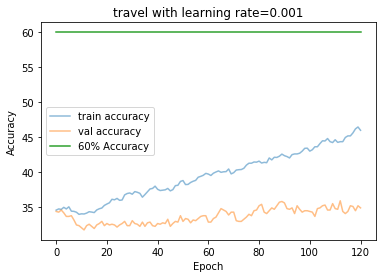

Running fine tune for travel
After training for 10 epochs, Train Acc 77.34002509410288, Val Acc 35.030549898167


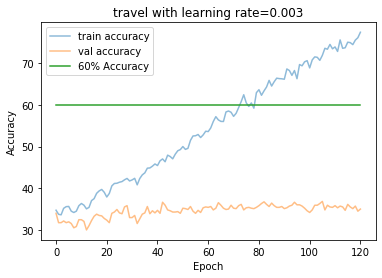

Running fine tune for travel
After training for 10 epochs, Train Acc 79.34755332496863, Val Acc 35.437881873727086


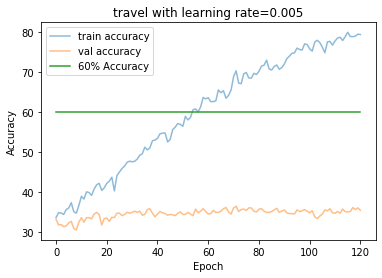

Running fine tune for fiction
After training for 10 epochs, Train Acc 46.27215849843587, Val Acc 34.472361809045225


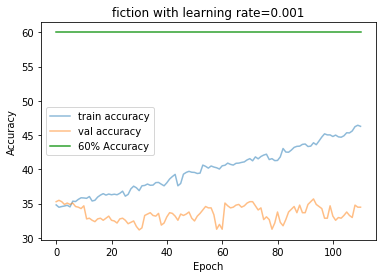

Running fine tune for fiction
After training for 10 epochs, Train Acc 68.76955161626694, Val Acc 36.08040201005025


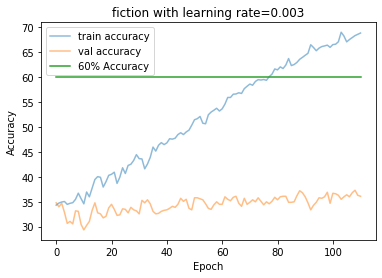

Running fine tune for fiction
After training for 10 epochs, Train Acc 72.96663190823774, Val Acc 35.07537688442211


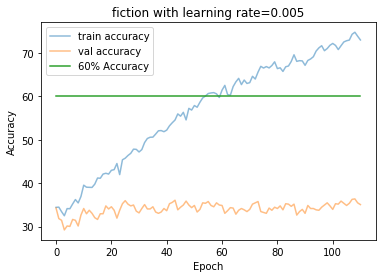

Running fine tune for government
After training for 10 epochs, Train Acc 46.0211176925058, Val Acc 33.95669291338583


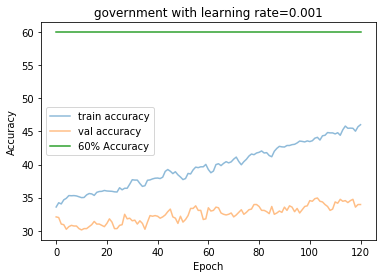

Running fine tune for government
After training for 10 epochs, Train Acc 71.10481586402267, Val Acc 35.72834645669291


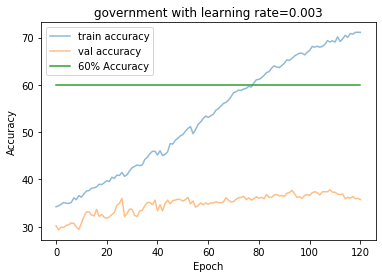

Running fine tune for government
After training for 10 epochs, Train Acc 74.06644347154263, Val Acc 37.5


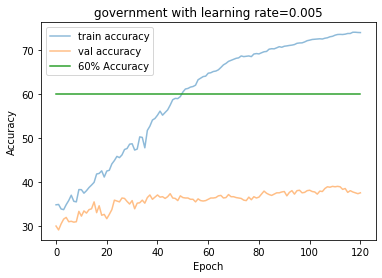

Running fine tune for slate
After training for 10 epochs, Train Acc 47.540983606557376, Val Acc 36.62674650698603


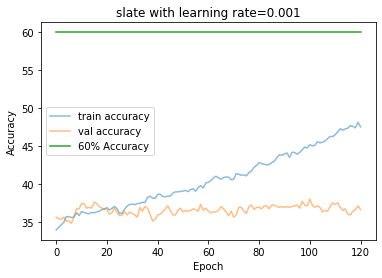

Running fine tune for slate
After training for 10 epochs, Train Acc 70.56631892697466, Val Acc 37.125748502994014


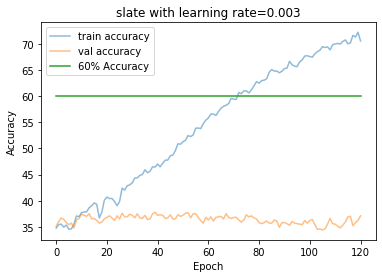

Running fine tune for slate
After training for 10 epochs, Train Acc 72.23050173869846, Val Acc 37.5249500998004


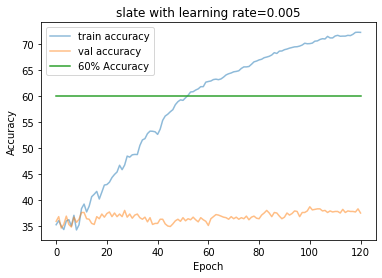

Running fine tune for telephone
After training for 10 epochs, Train Acc 45.76112412177986, Val Acc 37.3134328358209


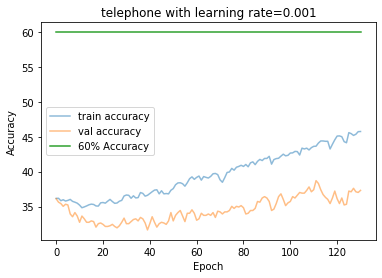

Running fine tune for telephone
After training for 10 epochs, Train Acc 74.07494145199063, Val Acc 37.711442786069654


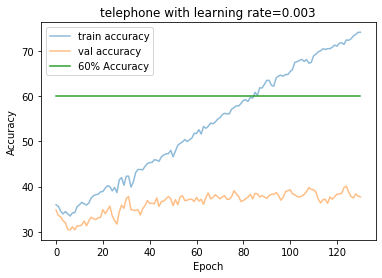

Running fine tune for telephone
After training for 10 epochs, Train Acc 79.88290398126463, Val Acc 37.51243781094527


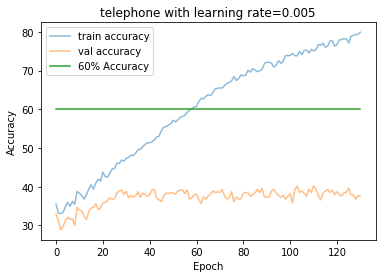

<Figure size 432x288 with 0 Axes>

In [7]:
genre_list = ['travel','fiction', 'government', 'slate', 'telephone']
learning_rate_list = [0.001,0.003,0.005]
MAX_SENTENCE_LENGTH = 100

for genre in genre_list:
    for learning_rate in learning_rate_list:
        train_list, val_list = fine_tune_pipeline(10000, 100, 32, 80, learning_rate, 0.08, 'concat',genre)
        plot_len = len(train_list)
        plt.plot(range(plot_len), train_list, label = 'train accuracy', alpha = 0.5)
        plt.plot(range(plot_len), val_list, label = 'val accuracy', alpha = 0.5)
        plt.plot(range(plot_len), [60]*plot_len, label  = '60% Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(genre+" with learning rate=" + str(learning_rate))
        plt.legend()
        plt.show()
        plt.clf()